In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns

## Get Data

In [2]:
data = datasets.load_diabetes()

all_data = pd.DataFrame(
    data['data'],
    columns=['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6']
)
all_data['target'] = data['target']


In [3]:
all_data

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


## Correlation

/var/folders/x7/_cy_rqsj03111rr15vx6_jh80000gn/T/ipykernel_24389/2689372629.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))


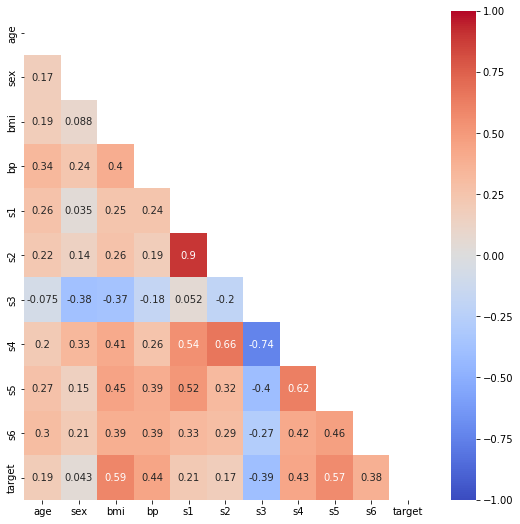

In [4]:
fig, ax = plt.subplots(1, figsize=(9,9))
mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(
    all_data.corr(), 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap='coolwarm', 
    mask=mask, 
    ax=ax
)
fig.savefig('correlation_plot.png', dpi=300)

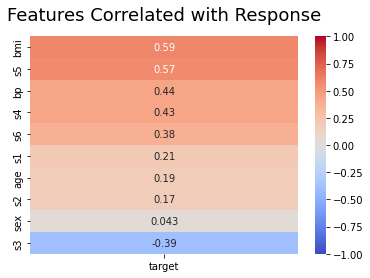

In [5]:
heatmap = sns.heatmap(
    all_data.corr()[['target']].sort_values(by='target', ascending=False).drop('target'),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='coolwarm')
heatmap.set_title(
    'Features Correlated with Response',
    fontdict={'fontsize':18},
    pad=16
);
fig = heatmap.get_figure()
fig.savefig('correlation_list.png', dpi=300) 

## Recursive Feature Eliminiation

In [6]:
y = data['target']
X = pd.DataFrame(
    data['data'], 
    columns=['age','sex','bmi','bp','s1','s2','s3','s4','s5','s6']
)
# this just converts sex back to a categorical variable
X.sex = X.sex.apply(lambda x: 1 if x > 0 else 0)

In [7]:
linear_model = LinearRegression()
linear_model.fit(X, y)

LinearRegression()

Shows how to get model coefficients from sklearn model

In [8]:
linear_model.coef_

array([ -10.0098663 ,  -22.85964809,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

Show how to get model intercept from sklearn model

In [9]:
linear_model.intercept_

162.8392469564116

## Recursive Feature Selection

In [10]:
rfecv = RFECV(
    estimator=linear_model,
    step=1,
    cv=2,
    scoring=make_scorer(mape ,greater_is_better=False),
    min_features_to_select=1
)
rfecv.fit(X,y)

RFECV(cv=2, estimator=LinearRegression(),
      scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [11]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 10


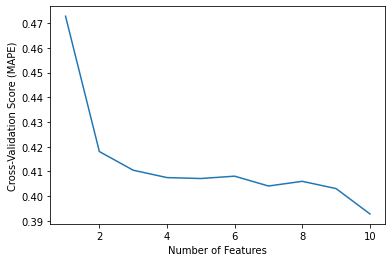

In [12]:
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    # need to negate sign here due to scorer behavior
    -rfecv.cv_results_['mean_test_score'],
)
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score (MAPE)");
plt.savefig("RFE_metric.png", dpi=300);

In [13]:
-rfecv.cv_results_['mean_test_score']

array([0.47278384, 0.41806721, 0.41052355, 0.40753408, 0.4071571 ,
       0.4081119 , 0.40412935, 0.40602803, 0.40308914, 0.39284634])